# Semantic Segmentation of Aeriel Imagery from Hurricane Harvey

The actual project work was a largely iterative process and trial of different model and techniques. The below set of code is the final developed methodology and training.



In [ ]:
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import json 
from pprint import pprint
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split #Load Data in dataloader and random split
from PIL import Image #For Image Processing
import tifffile as tiff #For Handling tiff
import glob #For reading and storing path directories
import cv2 #For Image Processing
import shutil #to be used to move files between folders
import os

from preprocessing import augment_images, patch_dataset #Import functions and classes defined in the attached preprocessing.py file
from metrics import accuracy, weighted_f1 #Import functions defined in the evaluation metrics.py

## Data Import and Visualization

In [ ]:
path = 'Dataset/'

df_train = pd.read_csv(path+'train.csv')
df_train.head()

,Unnamed: 0,image-id,image:01,date:01,type,geometry,label
0,0,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,121 1709 105 1842 97 2070 383 2094 369 2580 10...,Property Roof
1,1,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2716 2336 2877 2527 2939 2504 2953 2460 2927 2...,Vehicle
2,2,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2809 2171 3002 2419 3099 2363 3044 2287 2962 2...,Vehicle
3,3,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,3399 2922 3468 2918 3628 2952 3696 2894 3902 2...,Property Roof
4,4,6373eb4cbfe85a8192f99b74,gs://geoengine-dataset-houston-uav/rasters/719...,2017-08-31T00:00:00+00:00,polygon,2826 1633 3063 1909 3136 1872 3245 1772 3047 1...,Secondary Structure


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22419 entries, 0 to 22418
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  22419 non-null  int64 
 1   image-id    22419 non-null  object
 2   image:01    22419 non-null  object
 3   date:01     22419 non-null  object
 4   type        22419 non-null  object
 5   geometry    22419 non-null  object
 6   label       22419 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


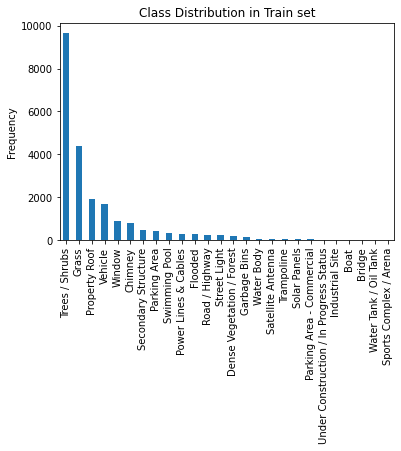

In [ ]:
#Train Data Label Distribution 
df_train.label.value_counts().plot.bar()
plt.ylabel('Frequency')
plt.title('Class Distribution in Train set')
plt.show()

## Data Pre-processing

Images shall all augmented at random using brightening/darkening, horizontal/vertical flips and rotation
techniques. Since the images are quite large, images shall be splits into smaller patches so that the model can capture model details. These shall be stored in a dataset object which would slow training since the augmented images are only split into a patch when called in the object. However, it saves the need to save the patches locally on the drive.

In [ ]:
#Create a new Training Images based on conditions set in augment_image function found in preprocessing.py
path = 'Dataset/'
train_img_path, train_msk_path = augment_images(image_path = path + 'train_images/',
                                                mask_path = path + 'train_masks/', parent_dir = path)

In [ ]:
#Create Train Dataset object using patch_dataset class defined in preprocessing.py
train_dataset = patch_dataset(sorted(glob.glob(train_img_path + '/*')),
                              sorted(glob.glob(train_msk_path+'/*')),patch_size_x = 1333, patch_size_y = 1500)

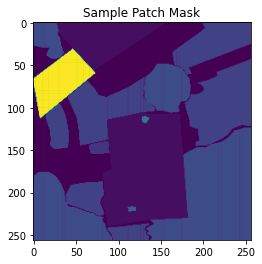

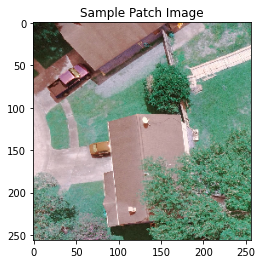

In [ ]:
#Example mask patch
rand_idx = np.random.randint(len(glob.glob(train_img_path + '/*')) - 1, dtype=int)
rand_patch_idx = np.random.randint(train_dataset[0][1].shape[0] - 1, dtype=int)
plt.figure()
plt.imshow(train_dataset[rand_idx][1][rand_patch_idx])
plt.title('Sample Patch Mask')
plt.show()
plt.figure()

plt.imshow(train_dataset[rand_idx][0][rand_patch_idx].permute(1,2,0).detach().numpy())
plt.title('Sample Patch Image')
plt.show()

## Model Training

The baseline architecture for this projects is a U-NET model who's architecture has been built has been built from scratch and can be found in the old files in the repository. For the final model trials, pre-trained U-NET and PSP-NET were used to boost performance.

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp # semantic segmentation library with pre-trained segmentation models
from torch.optim import lr_scheduler #learning rate schedules that decays learning rate during training

In [ ]:
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_set, test_set = random_split(train_dataset, [train_size, test_size])

In [ ]:
#small batch size chosen since each entry in a batch contains 6 patches. So each batch will contained 60 images to train on 
train_dataloader = DataLoader(train_set, batch_size=10, shuffle=True) 
val_dataloader = DataLoader(test_set, batch_size=10, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cpu


In [ ]:
lr = 0.001 #initial learning rate 
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
epochs = 30
lr_scheduler = lr_scheduler.PolynomialLR(optimizer,total_iters=25, power=0.9) #schedule to decay initial learning rate

In [ ]:
from models import train_UNet #function to train unet models from the models.py
from plot_utils import plot_losses #function to plot losses from plot_utils.py

### U-NET Training

In [ ]:
model_Unet = smp.Unet(
    encoder_name = 'resnet101', 
    encoder_weights = 'imagenet',
    in_channels = 3, 
    classes = 27, 
    decoder_channels=(512, 256, 128, 64, 32),
    activation = None, 
).to(device)

In [ ]:
from models import train_UNet #function created to train U-Net
from plot_utils import plot_losses #function creates to plot training losses

In [ ]:
model_Unet,total_train_losses, total_train_accuracy, total_train_f1, total_val_losses, total_val_accuracy, total_val_f1 = train_UNet(model_Unet, 
                                                                                                                                     optimizer, 
                                                                                                                                     epochs, 
                                                                                                                                     train_dataloader, 
                                                                                                                                     val_dataloader, 
                                                                                                                                     lr_scheduler, 
                                                                                                                                     device)

100%|██████████| 24/24 [08:38<00:00, 21.62s/it]


TRAIN       Epoch: 1 | Epoch metrics | loss: 2.3886, f1: 0.209, accuracy: 0.374


100%|██████████| 6/6 [02:21<00:00, 23.56s/it]


VAL       Epoch: 1 | Epoch metrics | loss: 2.5305, f1: 0.192, accuracy: 0.402


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 2 | Epoch metrics | loss: 1.4795, f1: 0.320, accuracy: 0.585


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 2 | Epoch metrics | loss: 2.0386, f1: 0.294, accuracy: 0.551


100%|██████████| 24/24 [01:46<00:00,  4.46s/it]


TRAIN       Epoch: 3 | Epoch metrics | loss: 1.2536, f1: 0.338, accuracy: 0.619


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 3 | Epoch metrics | loss: 1.3336, f1: 0.319, accuracy: 0.596


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 4 | Epoch metrics | loss: 1.1915, f1: 0.335, accuracy: 0.638


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 4 | Epoch metrics | loss: 1.3983, f1: 0.307, accuracy: 0.598


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 5 | Epoch metrics | loss: 1.1188, f1: 0.353, accuracy: 0.651


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 5 | Epoch metrics | loss: 1.2107, f1: 0.340, accuracy: 0.629


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 6 | Epoch metrics | loss: 1.1076, f1: 0.355, accuracy: 0.656


100%|██████████| 6/6 [00:26<00:00,  4.42s/it]


VAL       Epoch: 6 | Epoch metrics | loss: 1.0899, f1: 0.366, accuracy: 0.671


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 7 | Epoch metrics | loss: 1.0656, f1: 0.362, accuracy: 0.666


100%|██████████| 6/6 [00:26<00:00,  4.37s/it]


VAL       Epoch: 7 | Epoch metrics | loss: 1.1763, f1: 0.345, accuracy: 0.651


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 8 | Epoch metrics | loss: 1.0505, f1: 0.364, accuracy: 0.670


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 8 | Epoch metrics | loss: 1.0849, f1: 0.368, accuracy: 0.692


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 9 | Epoch metrics | loss: 0.9727, f1: 0.374, accuracy: 0.700


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 9 | Epoch metrics | loss: 1.0426, f1: 0.364, accuracy: 0.688


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 10 | Epoch metrics | loss: 0.9595, f1: 0.370, accuracy: 0.702


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 10 | Epoch metrics | loss: 1.1687, f1: 0.346, accuracy: 0.680


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 11 | Epoch metrics | loss: 0.9461, f1: 0.372, accuracy: 0.695


100%|██████████| 6/6 [00:26<00:00,  4.37s/it]


VAL       Epoch: 11 | Epoch metrics | loss: 1.0306, f1: 0.366, accuracy: 0.685


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 12 | Epoch metrics | loss: 0.9427, f1: 0.378, accuracy: 0.706


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 12 | Epoch metrics | loss: 1.0991, f1: 0.360, accuracy: 0.672


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 13 | Epoch metrics | loss: 0.9204, f1: 0.380, accuracy: 0.714


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 13 | Epoch metrics | loss: 1.0319, f1: 0.373, accuracy: 0.699


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 14 | Epoch metrics | loss: 0.9055, f1: 0.382, accuracy: 0.718


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 14 | Epoch metrics | loss: 0.9426, f1: 0.367, accuracy: 0.717


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 15 | Epoch metrics | loss: 0.8558, f1: 0.385, accuracy: 0.731


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 15 | Epoch metrics | loss: 0.9677, f1: 0.371, accuracy: 0.711


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 16 | Epoch metrics | loss: 0.8143, f1: 0.390, accuracy: 0.746


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 16 | Epoch metrics | loss: 0.9895, f1: 0.376, accuracy: 0.712


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 17 | Epoch metrics | loss: 0.8195, f1: 0.389, accuracy: 0.748


100%|██████████| 6/6 [00:26<00:00,  4.41s/it]


VAL       Epoch: 17 | Epoch metrics | loss: 0.9298, f1: 0.367, accuracy: 0.725


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 18 | Epoch metrics | loss: 0.7880, f1: 0.396, accuracy: 0.758


100%|██████████| 6/6 [00:26<00:00,  4.38s/it]


VAL       Epoch: 18 | Epoch metrics | loss: 0.9633, f1: 0.380, accuracy: 0.723


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 19 | Epoch metrics | loss: 0.7898, f1: 0.395, accuracy: 0.754


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 19 | Epoch metrics | loss: 0.9894, f1: 0.361, accuracy: 0.705


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 20 | Epoch metrics | loss: 0.7531, f1: 0.401, accuracy: 0.765


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 20 | Epoch metrics | loss: 0.9773, f1: 0.359, accuracy: 0.701


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 21 | Epoch metrics | loss: 0.7235, f1: 0.403, accuracy: 0.779


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 21 | Epoch metrics | loss: 0.9819, f1: 0.373, accuracy: 0.699


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 22 | Epoch metrics | loss: 0.6899, f1: 0.409, accuracy: 0.791


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 22 | Epoch metrics | loss: 0.8561, f1: 0.390, accuracy: 0.749


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 23 | Epoch metrics | loss: 0.6608, f1: 0.412, accuracy: 0.803


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 23 | Epoch metrics | loss: 0.8517, f1: 0.388, accuracy: 0.747


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 24 | Epoch metrics | loss: 0.6432, f1: 0.417, accuracy: 0.806


100%|██████████| 6/6 [00:26<00:00,  4.42s/it]


VAL       Epoch: 24 | Epoch metrics | loss: 0.9103, f1: 0.385, accuracy: 0.725


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 25 | Epoch metrics | loss: 0.6389, f1: 0.416, accuracy: 0.811


100%|██████████| 6/6 [00:26<00:00,  4.39s/it]


VAL       Epoch: 25 | Epoch metrics | loss: 0.8720, f1: 0.393, accuracy: 0.754


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 26 | Epoch metrics | loss: 0.6208, f1: 0.420, accuracy: 0.818


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 26 | Epoch metrics | loss: 1.1135, f1: 0.387, accuracy: 0.736


100%|██████████| 24/24 [01:46<00:00,  4.45s/it]


TRAIN       Epoch: 27 | Epoch metrics | loss: 0.5987, f1: 0.422, accuracy: 0.824


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 27 | Epoch metrics | loss: 0.8872, f1: 0.388, accuracy: 0.743


100%|██████████| 24/24 [01:46<00:00,  4.43s/it]


TRAIN       Epoch: 28 | Epoch metrics | loss: 0.5694, f1: 0.427, accuracy: 0.834


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 28 | Epoch metrics | loss: 0.8422, f1: 0.391, accuracy: 0.748


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 29 | Epoch metrics | loss: 0.5450, f1: 0.432, accuracy: 0.843


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]


VAL       Epoch: 29 | Epoch metrics | loss: 0.8239, f1: 0.395, accuracy: 0.760


100%|██████████| 24/24 [01:46<00:00,  4.44s/it]


TRAIN       Epoch: 30 | Epoch metrics | loss: 0.5062, f1: 0.437, accuracy: 0.855


100%|██████████| 6/6 [00:26<00:00,  4.40s/it]

VAL       Epoch: 30 | Epoch metrics | loss: 0.8563, f1: 0.393, accuracy: 0.753


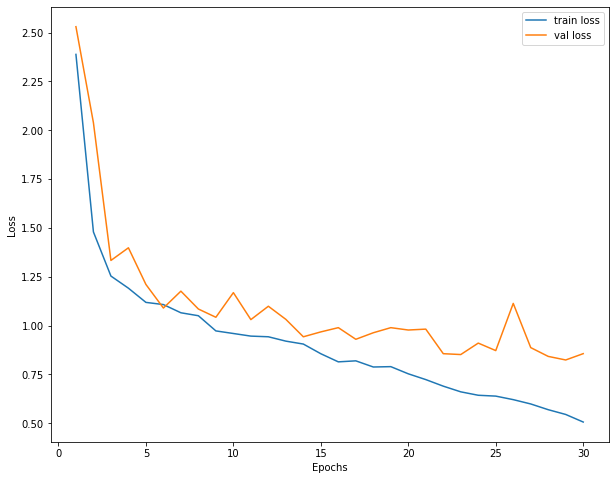

In [ ]:
plot_losses(total_train_losses, total_val_losses)

### PSP-NET Training

SECTION UNDER CONSTRUCTION

## Sample Model Outputs

Since PSP-Net outperformed the U-Net model, it was used as out final model for submissions. Below are some of the sample predictive outputs from the model.

SECTION UNDER CONSTRUCTION